### Visual Attention Mechanism


Reference:
[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

`Some parts of the code were modified and comment lines were added.`

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
physical_devices = tf.config.experimental.list_physical_devices('GPU')

try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[0:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  print(physical_devices)
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")
  pass
'''

'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\n\ntry:\n  # Disable first GPU\n  tf.config.set_visible_devices(physical_devices[0:], \'GPU\')\n  logical_devices = tf.config.list_logical_devices(\'GPU\')\n  print(physical_devices)\n  # Logical device was not created for first GPU\n  assert len(logical_devices) == len(physical_devices) - 1\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  print("Invalid device or cannot modify virtual devices once initialized.")\n  pass\n'

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/yoshua_paper_results.png)

Reference: [Neural Machine Translation by Jointly Learning to Align and Translate
](https://arxiv.org/abs/1409.0473)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/attention_examples.png)

Reference:
[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/se_example_2.png)

Reference:
[Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_1.png)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_2.png)

Reference:
[CBAM: Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)

In [37]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [38]:
from utils import vision
from utils import utils
from utils import losses

In [3]:
experiment = {
    'IMAGE_SIZE': (32, 32),
    'INPUT_SHAPE': (32, 32, 3),

    'ACCELERATOR': 'GPU',  # Or 'TPU'

    'BATCH_SIZE': 32,
    'EPOCHS': 20,
    'AUTOTUNE': tf.data.experimental.AUTOTUNE,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0001,  # 1e-4

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_visual_attention_mechanism/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_visual_attention_mechanism/images",
}

In [4]:
class ChannelGate(tf.keras.layers.Layer):
  # Reference: https://arxiv.org/abs/1807.06521
  def __init__(self, gate_channels, reduction_ratio, pool_types=['avg', 'max']):
    super(ChannelGate, self).__init__()
    # Check valid pool types
    valid_pool_types = ['avg', 'max', 'lp', 'lse']
    for pool_type in pool_types:
        assert(pool_type in valid_pool_types)
    self.pool_types = pool_types

    self.gate_channels = gate_channels
    self.reduction_ratio = reduction_ratio

    # MLP (Multi Layer Perceptron)
    self.mlp = tf.keras.Sequential([
        #Flatten(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(self.gate_channels // self.reduction_ratio),
        #tf.keras.layers.Dense(self.gate_channels // self.reduction_ratio,
        #                      kernel_initializer='he_normal', use_bias=True,
        #                      bias_initializer='zeros'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(self.gate_channels)
        #tf.keras.layers.Dense(self.gate_channels, kernel_initializer='he_normal',
        #                      use_bias=True, bias_initializer='zeros')
    ])

  def logsumexp_2d(self, tensor):
    tensor_flatten = tf.reshape(tensor, (tf.shape(tensor)[0], tf.shape(tensor)[1], -1))
    s = tf.reduce_max(tensor_flatten, axis=2, keepdims=True)
    outputs = s + tf.math.log(tf.reduce_sum(tf.math.exp(tensor_flatten - s), axis=2, keepdims=True))
    return outputs

  def call(self, inputs):
    pooling_list = []
    if 'avg' in self.pool_types:
        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        #avg_pool = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)
        avg_pool = self.mlp(avg_pool)
        pooling_list.append(avg_pool)
    elif 'max' in self.pool_types:
        max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
        max_pool = tf.keras.layers.Reshape((1,1, self.gate_channels))(max_pool)
        #max_pool = tf.reduce_max(inputs, axis=[2, 3], keepdims=True)
        max_pool = self.mlp(max_pool)
        pooling_list.append(max_pool)
    elif 'lp' in self.pool_types:
        lp_pool = tf.norm(inputs, ord=2, axis=[2, 3], keepdims=True)
        lp_pool = self.mlp(lp_pool)
        pooling_list.append(lp_pool)
    elif 'lse' in self.pool_types:
        lse_pool = self.logsumexp_2d(inputs)
        lse_pool = self.mlp(lse_pool)
        pooling_list.append(lse_pool)

    attention = tf.keras.layers.Add()(pooling_list)
    attention = tf.keras.layers.Activation('sigmoid')(attention)
    # tf.keras.layers.Multiply: It takes a list of tensors as input and computes
    # the element-wise product of those tensors, assuming they have the same shape.
    return tf.keras.layers.Multiply()([inputs, attention])

In [5]:
import tensorflow as tf

class Conv2DLayerBN(tf.keras.layers.Conv2D):
    '''
    act_end: Activation function for end of the conv + BN -> conv + BN + Act
    batch_norm: Batch normalization
    lrelu_alpha: Leaky ReLU activation function alpha
    '''
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid',
                 activation=None,act_end=None, batch_norm=True, lrelu_alpha=0.3,
                 *args, **kwargs):
        # Call the constructor of the base class (tf.keras.layers.Conv2D)
        super(Conv2DLayerBN, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=activation,
            *args,
            **kwargs
        )
        act_funcs = ["relu", "lrelu", "sigmoid"]
        assert((act_end == None) or (act_end in act_funcs))

        self.batch_norm = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01) if batch_norm else None

        if act_end == "relu":
            #act_func = tf.nn.relu()
            self.activation = tf.keras.layers.Activation(act_end)
        elif act_end == "lrelu":
            act_func = tf.nn.leaky_relu(alpha=lrelu_alpha)
            self.activation = tf.keras.layers.Activation(act_func)
        elif act_end == "sigmoid":
            #act_func = tf.keras.activations.sigmoid()
            self.activation = tf.keras.layers.Activation(act_end)
        else:
            self.activation = None

        # ..Add additional customization or modifications...

        # __________________________________________________

    def build(self, input_shape):
        # Add any additional setup or customization for the layer's weights here
        # This method is called the first time the layer is used, based on the input_shape.

        # Make sure to call the build method of the base class
        super(Conv2DLayerBN, self).build(input_shape)

    def call(self, inputs):
        # You can access the weights using self.weights and perform computations using TensorFlow operations.
        # Example:
        # output = tf.nn.conv2d(inputs, self.kernel, strides=self.strides, padding=self.padding)
        # if self.activation is not None:
        #     output = self.activation(output)
        # return output

        # ...Add forward pass activations here...

        # ______________________________________
        x = super(Conv2DLayerBN, self).call(inputs)
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

    def get_config(self):
        # ...Add additional configuration parameters for serialization...

        # _______________________________________________________________
        # This method is used to save the configuration of the layer when the model is saved.
        config = super(Conv2DLayerBN, self).get_config()
        # Add your custom parameters to config dictionary
        return config


In [6]:
class ChannelPool(tf.keras.layers.Layer):
    '''
    ChannelPool
    Calculate Max and Avg. pooling for given tensor
    Concatenate them to produce a tensor for being input of MLP
    '''
    def call(self, x):
        max_pool = tf.expand_dims(tf.reduce_max(x, axis=1), axis=1)
        mean_pool = tf.expand_dims(tf.reduce_mean(x, axis=1), axis=1)
        return tf.concat([max_pool, mean_pool], axis=1)

In [25]:
class SpatialGate(tf.keras.layers.Layer):
  # Reference: https://arxiv.org/abs/1807.06521
  def __init__(self, kernel_size, stride=1):
    super(SpatialGate, self).__init__()

    self.padding='valid' if ((kernel_size-1) // 2) == 0 else 'same'
    self.spatial = Conv2DLayerBN(filters=1, kernel_size=kernel_size, strides=stride,
                         padding=self.padding, act_end='sigmoid', batch_norm=True)

  def call(self, inputs):
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

    # tf.keras.layers.Concatenate: takes a list of tensors as input and concatenates
    # them along the specified axis to produce a single tensor.
    attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = self.spatial(attention)

    return tf.keras.layers.multiply([inputs, attention])

### Build a Model

In [8]:
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                      shuffle_files=True, as_supervised=True,
                                      with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8L4FX9/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8L4FX9/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [9]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmp35sa8rsdtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

In [10]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
def visualize_images(image_batch):
  index = 0
  for image, label in image_batch.take(10):
    plt.subplot(2, 5, index + 1)
    index += 1
    plt.imshow(image[:])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

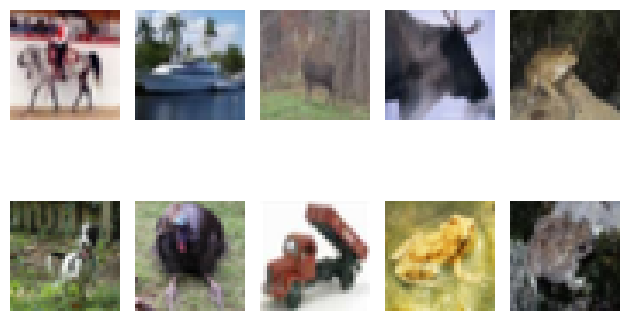

In [13]:
visualize_images(ds_train)

In [14]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

### Prepare Dataset

In [15]:
ds_train = ds_train.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

In [16]:
ds_test = ds_test.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_test = ds_test.cache().batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

### Build a Network without Attention

In [17]:
def get_cnn_model_without_attention(verbose=0):
    input = tf.keras.layers.Input(shape=ds_info.features['image'].shape, name='Input_Layer')
    x = Conv2DLayerBN(32, 3, strides=1, padding="same", act_end='relu')(input)
    x = Conv2DLayerBN(32, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerBN(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = Conv2DLayerBN(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerBN(128, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu')(x)
    # No batch normalization after last Conv block

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(ds_info.features['label'].num_classes,
                              activation='softmax' )(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    if verbose > 0:  model.summary()
    return model

In [18]:
'''
# Equivalent code using Sequential API
def get_cnn_model_without_attention(verbose=0):
    model = tf.keras.models.Sequential([
        Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,
                      act_end='relu', padding='same', batch_norm=True),
        Conv2DLayerBN(32, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),
        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),
        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])

    if verbose > 0:  model.summary()
    return model
'''

" \n# Equivalent code using Sequential API\ndef get_cnn_model_without_attention(verbose=0):\n    model = tf.keras.models.Sequential([\n        Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape, \n                      act_end='relu', padding='same', batch_norm=True), \n        Conv2DLayerBN(32, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),\n        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),\n        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.GlobalAveragePooling2D(),\n        tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )\n    ])\n    \n    if verbose > 0:  model.summary()\n   

In [19]:
simple_cnn_no_attention = get_cnn_model_without_attention(verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_layer_bn (Conv2DLay  (None, 32, 32, 32)        1024      
 erBN)                                                           
                                                                 
 conv2d_layer_bn_1 (Conv2DL  (None, 32, 32, 32)        9376      
 ayerBN)                                                         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_layer_bn_2 (Conv2DL  (None, 16, 16, 64)        18752     
 ayerBN)                                                     

In [20]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [21]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [22]:
model_hist = simple_cnn_no_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 34s 9ms/step - loss: 1.2040 - accuracy: 0.5675
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7962 - accuracy: 0.7202
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6332 - accuracy: 0.7797
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5358 - accuracy: 0.8148
Epoch 5/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.4620 - accuracy: 0.8393
Epoch 6/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3991 - accuracy: 0.8617
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.3513 - accuracy: 0.8782
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3039 - accuracy: 0.8921
Epoch 9/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2591 - accuracy: 0.9077
Epoch 10/20
1563/1563 [==============================] - 11s 7ms/step - l

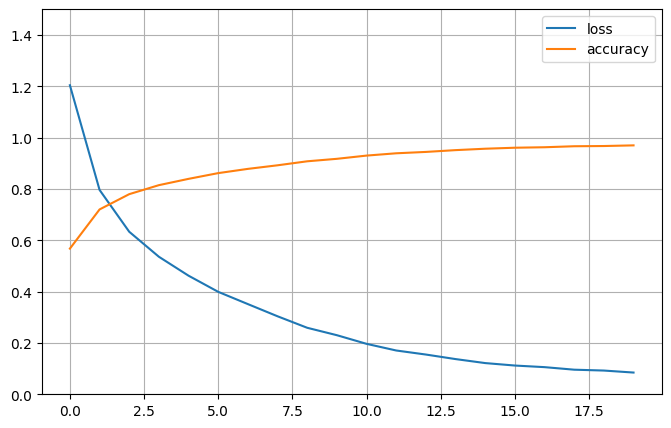

In [23]:
import pandas as pd

pd.DataFrame(model_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [24]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 10ms/step - loss: 0.9865 - accuracy: 0.7973
Test accuracy: 0.7972999811172485


### Build a Network with Attention

In [28]:
def get_cnn_model_with_attention(verbose=0):
    model = tf.keras.Sequential([
    Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,
                  act_end='relu', padding='same'),
    Conv2DLayerBN(32, 3, padding='same', act_end='relu'),

    ChannelGate(32, 8),
    SpatialGate(7),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),
    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),

    ChannelGate(64, 8),
    SpatialGate(7),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Conv2DLayerBN(128, 3, padding='same', act_end='relu'),

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),

    ChannelGate(128, 8),
    SpatialGate(7),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])
    if verbose > 0:  model.summary()

    return model

In [29]:
simple_cnn_with_attention = get_cnn_model_with_attention(verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_layer_bn_12 (Conv2D  (None, 32, 32, 32)        1024      
 LayerBN)                                                        
                                                                 
 conv2d_layer_bn_13 (Conv2D  (None, 32, 32, 32)        9376      
 LayerBN)                                                        
                                                                 
 channel_gate_2 (ChannelGat  (None, 32, 32, 32)        292       
 e)                                                              
                                                                 
 spatial_gate_2 (SpatialGat  (None, 32, 32, 32)        103       
 e)                                                              
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)       

In [30]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [31]:
history = simple_cnn_with_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 27s 13ms/step - loss: 1.2193 - accuracy: 0.5591
Epoch 2/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7682 - accuracy: 0.7310
Epoch 3/20
1563/1563 [==============================] - 23s 14ms/step - loss: 0.6125 - accuracy: 0.7859
Epoch 4/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.5178 - accuracy: 0.8189
Epoch 5/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.4475 - accuracy: 0.8448
Epoch 6/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.3915 - accuracy: 0.8624
Epoch 7/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.3343 - accuracy: 0.8821
Epoch 8/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.2900 - accuracy: 0.8977
Epoch 9/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.2516 - accuracy: 0.9104
Epoch 10/20
1563/1563 [==============================] - 20s 13m

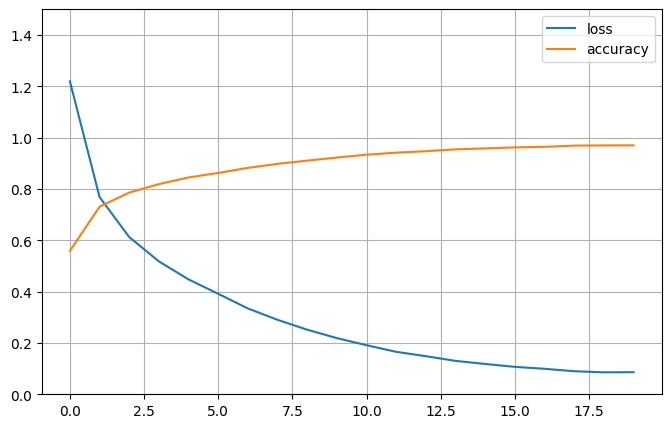

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [33]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8438 - accuracy: 0.8207
Test accuracy: 0.8206999897956848


### Visualize Attention network

In [34]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (32, 32, 32, 3)
y_test.shape: (32,)


In [35]:
def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")

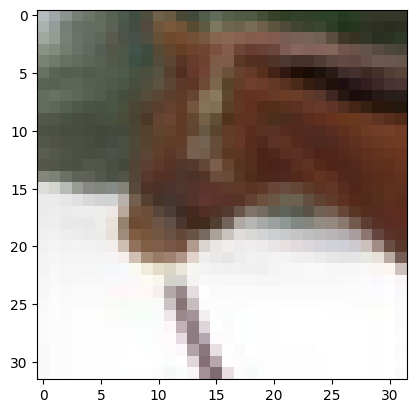

In [39]:
plt.imshow(X_test[0])

### Network without vs with Attention

1/1 [==============================] - 0s 26ms/step


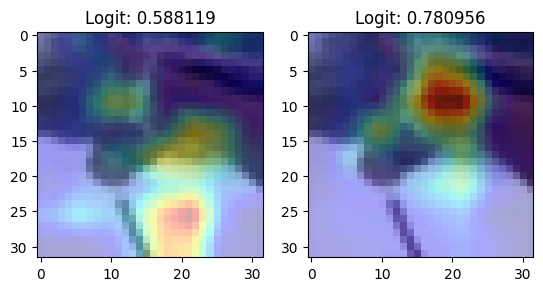

In [69]:
test_id = 0

test_img = X_test[test_id]
test_img = tf.expand_dims(test_img, axis=0)

# CNN model with Attention
gradCam_att_cnn = vision.GradCAM(simple_cnn_with_attention)
preds_att_cnn = simple_cnn_with_attention.predict(X_test)
class_id_att_cnn = np.argmax(preds_att_cnn[test_id])
(heatmap_att_cnn, output_att_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_att_cnn, alpha=0.5)


# Simple CNN model
gradCam_cnn = vision.GradCAM(simple_cnn_no_attention)
preds_cnn = simple_cnn_no_attention.predict(X_test)
class_id_cnn = np.argmax(preds_cnn[test_id])
(heatmap_cnn, output_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_cnn, alpha=0.5)


plt.subplot(1,2,1)
plt.imshow(output_att_cnn)
plt.title(f"Logit: {preds_att_cnn[0][class_id_att_cnn]:2f}")
plt.subplot(1,2,2)
plt.imshow(output_cnn)
plt.title(f"Logit: {preds_cnn[0][class_id_cnn]:2f}")
plt.show()

In [71]:
def show_GradCAM_results(test_id):
    test_img = X_test[test_id]
    test_img = tf.expand_dims(test_img, axis=0)

    # CNN model with Attention
    gradCam_att_cnn = vision.GradCAM(simple_cnn_with_attention)
    preds_att_cnn = simple_cnn_with_attention.predict(X_test)
    class_id_att_cnn = np.argmax(preds_att_cnn[test_id])
    (heatmap_att_cnn, output_att_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_att_cnn, alpha=0.5)


    # Simple CNN model
    gradCam_cnn = vision.GradCAM(simple_cnn_no_attention)
    preds_cnn = simple_cnn_no_attention.predict(X_test)
    class_id_cnn = np.argmax(preds_cnn[test_id])
    (heatmap_cnn, output_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_cnn, alpha=0.5)


    plt.subplot(1,2,1)
    plt.imshow(output_att_cnn)
    plt.title(f"Logit: {preds_att_cnn[0][class_id_att_cnn]:2f}")
    plt.subplot(1,2,2)
    plt.imshow(output_cnn)
    plt.title(f"Logit: {preds_cnn[0][class_id_cnn]:2f}")
    plt.show()

1/1 [==============================] - 0s 81ms/step


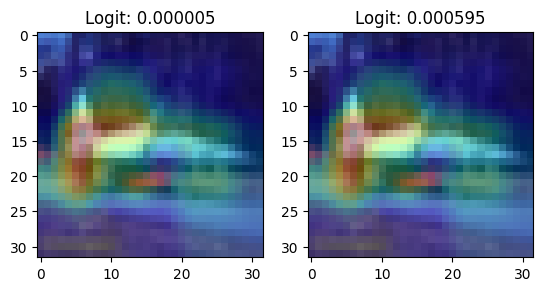

In [72]:
show_GradCAM_results(1)

1/1 [==============================] - 0s 24ms/step


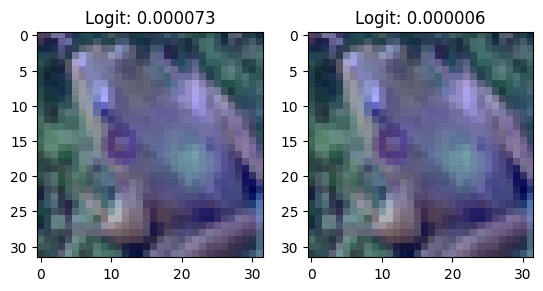

In [73]:
show_GradCAM_results(2)

1/1 [==============================] - 0s 28ms/step


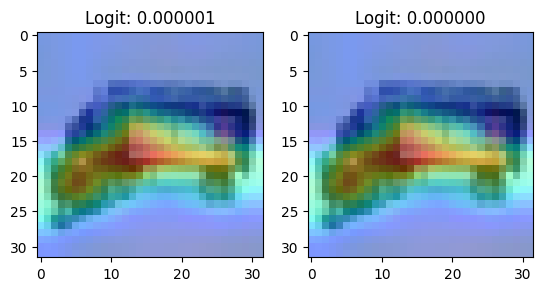

In [74]:
show_GradCAM_results(3)

1/1 [==============================] - 0s 48ms/step


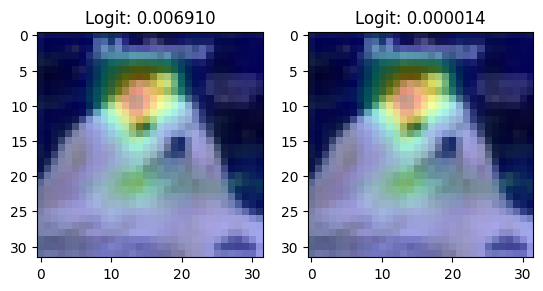

In [75]:
show_GradCAM_results(4)

### Reference

[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/display.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/saver.py

https://www.youtube.com/watch?v=1mjI_Jm4W1E
